Imagine we have a tile of locations, say "cortical columns" that tile the visual field. 

Each column represents a patch of the full visual space. And each patch encodes the visual features with the same set of sparse filters and code words.



In [1]:
from __future__ import division

import scipy
import time
import utils
import hrr_utils
import sklearn
import sklearn.metrics as metrics
import numpy as np
import imnet_utils as imut

from pylab import *
from sklearn.decomposition import PCA, FastICA, TruncatedSVD, NMF
from sklearn.datasets import load_digits
from mnist import MNIST
import matplotlib.pyplot as plt 

%matplotlib inline

plt.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rcParams.update({'axes.labelsize': 'xx-large'})
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'})
plt.rcParams.update({'legend.fontsize': 'x-large'})
plt.rcParams.update({'text.usetex': True})


In [2]:
NUM_CLASSES = 10

def load_dataset():
    mndata = MNIST('data/mnist/')
    X_train, labels_train = map(np.array, mndata.load_training())
    X_test, labels_test = map(np.array, mndata.load_testing())
    X_train = X_train/255.0
    X_test = X_test/255.0
    X_train = np.resize(X_train, (X_train.shape[0], 28, 28))
    X_test = np.resize(X_test, (X_test.shape[0], 28, 28))
    return (X_train, labels_train), (X_test, labels_test)

def load_patches(imgs, num_imgs, patch_size=(5,5)):
    im_patches = np.zeros((patch_size[0], patch_size[1], num_imgs))
    indices = np.random.choice(imgs.shape[0], num_imgs, replace=False)
    for i in range(num_imgs):
        im = imgs[indices[i]]
        randr_st = np.random.randint(im.shape[0] - patch_size[0]-1)
        randc_st = np.random.randint(im.shape[1] - patch_size[1]-1)
        im_patches[:,:,i] = im[randr_st:(randr_st + patch_size[0]), 
                                    randc_st:(randc_st + patch_size[1])]
    return im_patches+1
    
def load_random_patches(train, test, num_imgs=10, patch_size=(5,5)):
    train_patches = load_patches(train, int(num_imgs*.8), patch_size)
    test_patches = load_patches(test, int(num_imgs*.2), patch_size)
    return train_patches, test_patches

def clip(img):
    cimg = img.copy()
    cimg[cimg > 1] = 1
    cimg[cimg < 1] = -1
    return cimg

def norm_range(v):
    return (v-v.min())/(v.max()-v.min())

In [3]:
(X_train, labels_train), (X_test, labels_test) = load_dataset()

In [4]:
print X_train.shape

(60000, 28, 28)


In [11]:
reload(imut)
patch_size=(5,5)
num_imgs=1000
tstart = time.time()

train_impatches, test_impatches = load_random_patches(X_train, X_test, num_imgs, patch_size=patch_size)

# take a random number, then take a random patch in the number, then do that 100k times

print "Duration: ", time.time() - tstart


Duration:  0.0629730224609


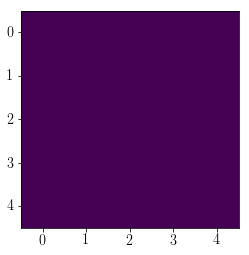

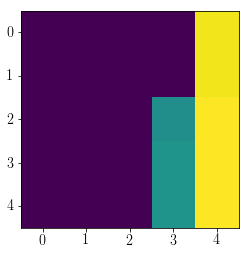

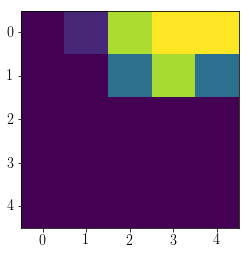

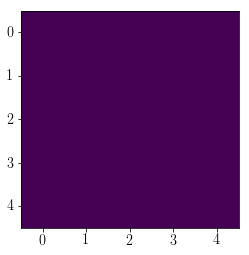

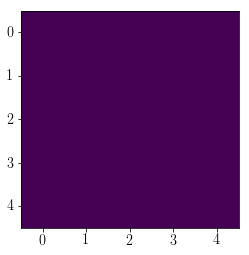

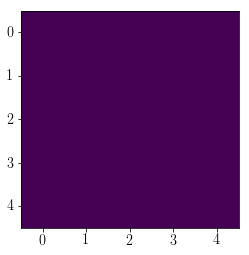

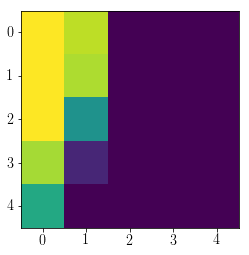

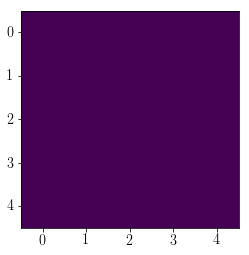

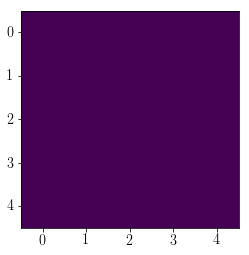

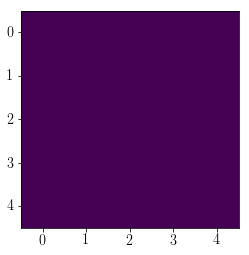

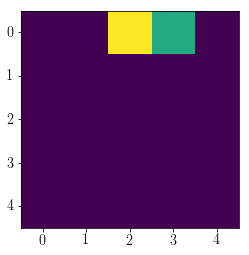

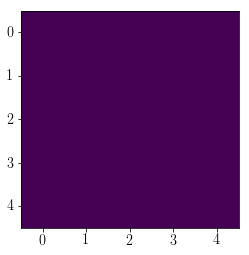

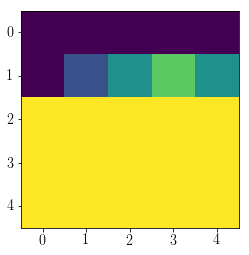

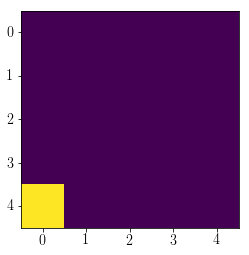

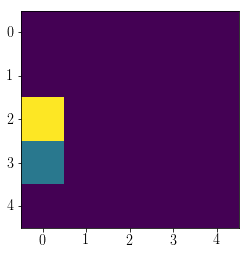

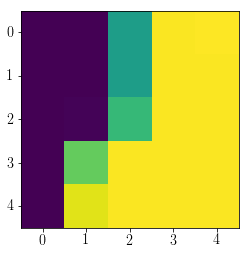

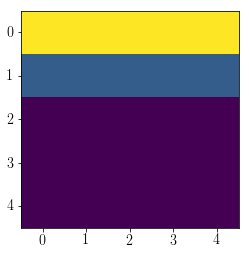

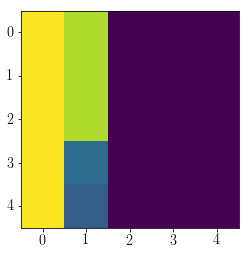

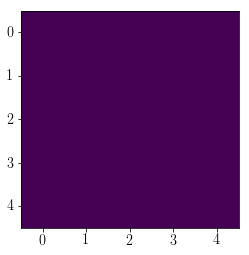

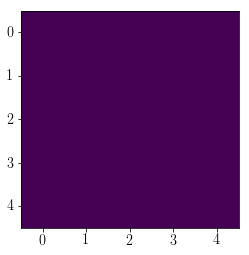

In [6]:
for i in range(test_impatches.shape[2]):
    plt.figure()
    plt.imshow((test_impatches[:,:,i]-1)/255)
    plt.show()

(25, 800)


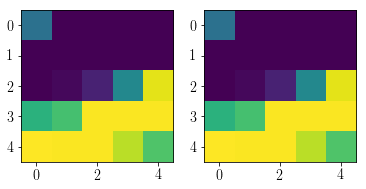

In [12]:
impatchr = train_impatches.copy().reshape((-1, train_impatches.shape[2]))
print impatchr.shape
impatchr -= 1
impatchr /= 255

irec = impatchr[:,22].reshape((train_impatches.shape[0], train_impatches.shape[1]))

subplot(121)
imshow((train_impatches[:,:,22]-1)/255)
subplot(122)
imshow(irec)

In [13]:
mean01 = impatchr.mean()
impatchr -= mean01


In [16]:
ncomponents = min(25, patch_size[0]*patch_size[1]*3-1)

#pca_encoder = TruncatedSVD(ncomponents)
pca_encoder = PCA(ncomponents)
fica_encoder = FastICA(ncomponents)

In [17]:
tstart = time.time()
pca_encoder.fit(impatchr.T)
print 'Duration: ', time.time() - tstart

Duration:  0.0418910980225


In [18]:
scores = pca_encoder.transform(impatchr.T)

In [23]:
pc_comp = pca_encoder.components_

print pc_comp.shape

pc_comp_ims = pc_comp.T.reshape((train_impatches.shape[0], train_impatches.shape[1], -1))



(25, 25)


IndexError: index 25 is out of bounds for axis 2 with size 25

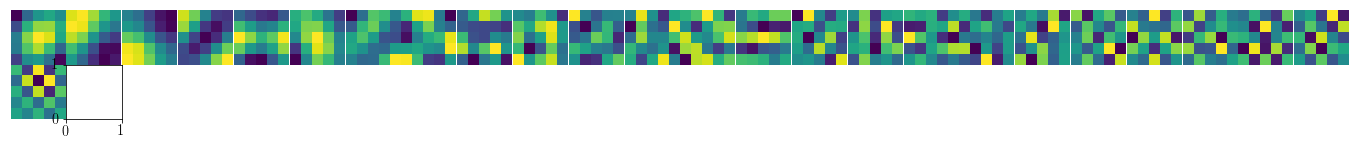

In [27]:
plt.rcParams['figure.subplot.hspace'] = 0
plt.rcParams['figure.subplot.wspace'] = 0

figure(figsize=(24,10))

nshow = 240
maxrow = 24
for i in range(nshow):
    ax=subplot(nshow//maxrow,maxrow,i+1)
    imshow(norm_range(pc_comp_ims[:,:,i]))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)


In [29]:
tstart = time.time()
which_pcs = np.arange(scores.shape[1])
fica_encoder.fit(scores[:,which_pcs])
print 'Duration: ', time.time() - tstart


Duration:  0.110975027084


In [30]:
ic_scores = fica_encoder.transform(scores[:1000,which_pcs])

In [31]:
pc_scores = scores[:ic_scores.shape[0], :ic_scores.shape[1]]


In [32]:
ic_comp = fica_encoder.components_
ic_comp /= ic_comp.std(axis=0)
ic_comp = np.dot(ic_comp, pc_comp[which_pcs,:])
print ic_comp.shape

(25, 25)


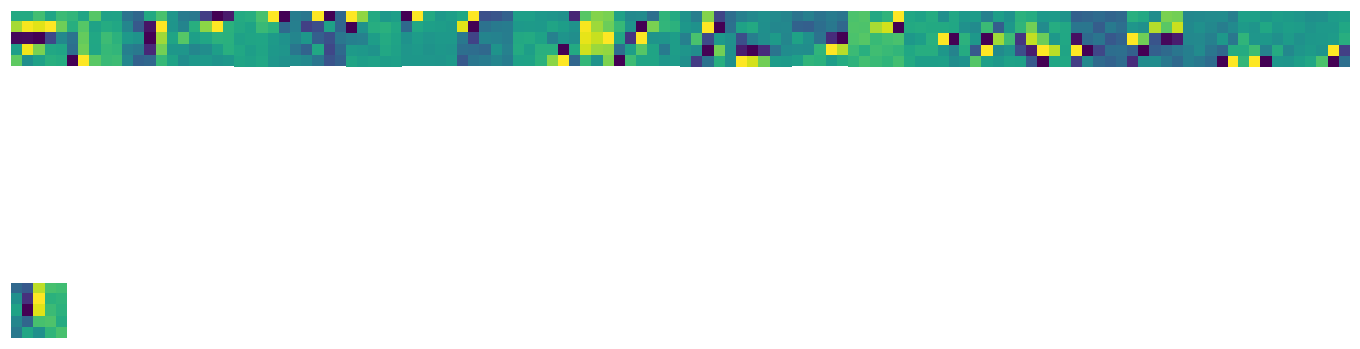

In [36]:
ic_comp_ims = ic_comp.T.reshape((train_impatches.shape[0], train_impatches.shape[1], -1))
figure(figsize=(24,10))
nshow = min(len(which_pcs), 240)
maxrow = 24
for i in range(nshow):
    ax=subplot(nshow//maxrow+1,maxrow,i+1)
    imshow(norm_range(ic_comp_ims[:,:,i+0]))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)


In [40]:
reload(imut)
nrecon = 16
ic_c = linalg.lstsq(ic_comp.T, impatchr)
pc_c = linalg.lstsq(pc_comp[which_pcs,:].T, impatchr)
ic_code = ic_c[0].T
pc_code = pc_c[0].T

/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/home/quinn/miniconda2/lib/python2.7/site-packages/matplotlib/colors.py:823: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/quinn/miniconda2/lib/python2.7/site-packages/numpy/ma/core.py:2809: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


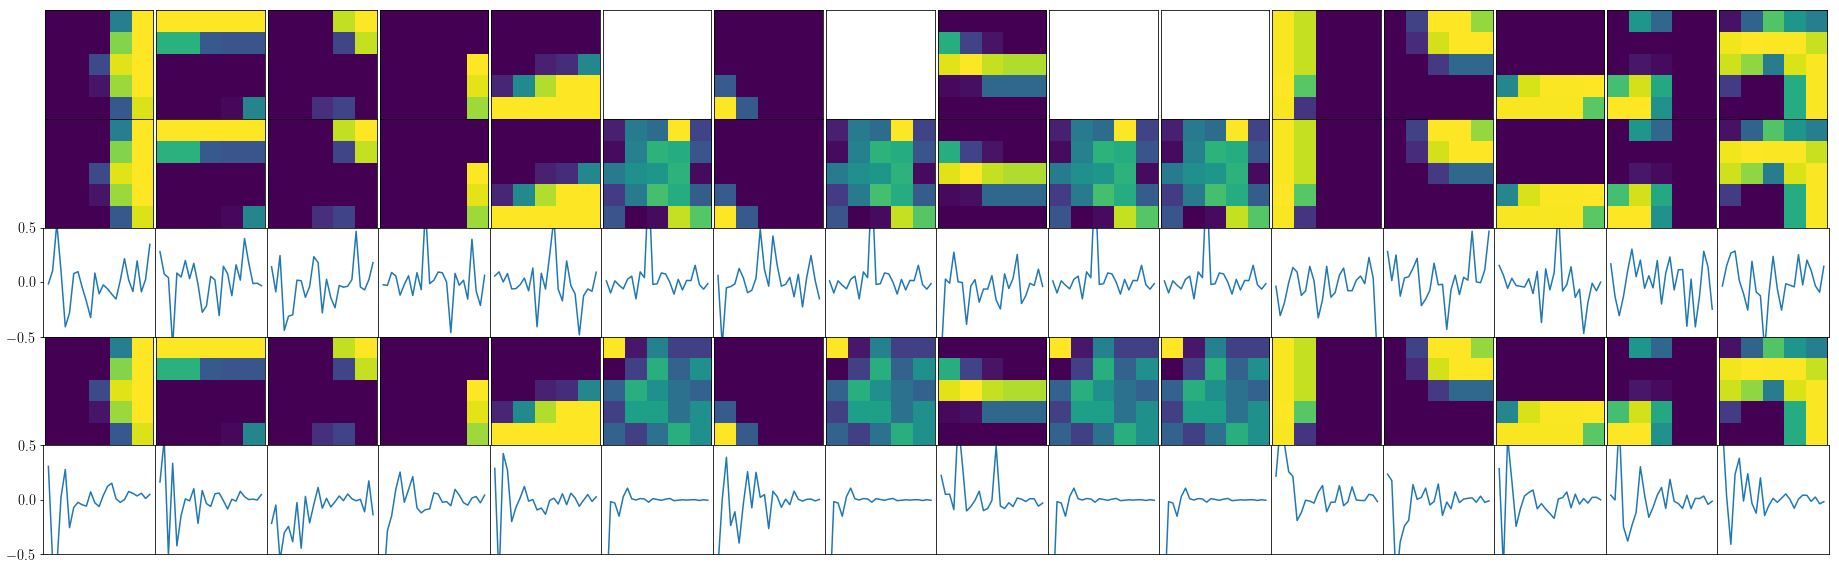

In [42]:


figure(figsize=(32, 10))

for imx in range(nrecon):
    
    ax = subplot(5, nrecon, imx + 1)
    imp = impatchr[:,imx].reshape(patch_size[0], patch_size[1])
    imshow(norm_range(imp))
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = subplot(5, nrecon, imx + 1 + nrecon)
    ic_recon = np.dot(ic_code[imx,:], ic_comp)
    ic_reconr = ic_recon.reshape(patch_size[0], patch_size[1])
    imshow(norm_range(ic_reconr))
    ax.set_xticks([])
    ax.set_yticks([])
    
    
    ax = subplot(5, nrecon, imx + 1 + 2*nrecon)
    plot(ic_code[imx,:].T/norm(ic_code[imx, :]))
    ax.set_xticks([])
    ax.set_ylim([-0.5, 0.5])
    if imx > 0:
        ax.set_yticks([])

    ax = subplot(5, nrecon, imx + 1 + 3*nrecon)
    pc_recon = np.dot(pc_code[imx,:], pc_comp[which_pcs,:])
    pc_reconr = pc_recon.reshape(patch_size[0], patch_size[1])
    imshow(norm_range(pc_reconr))
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = subplot(5, nrecon, imx + 1 + 4*nrecon)
    plot(pc_code[imx,:].T/norm(pc_code[imx, :]))
    ax.set_xticks([])
    ax.set_ylim([-0.5, 0.5])
    if imx > 0:
        ax.set_yticks([])


/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


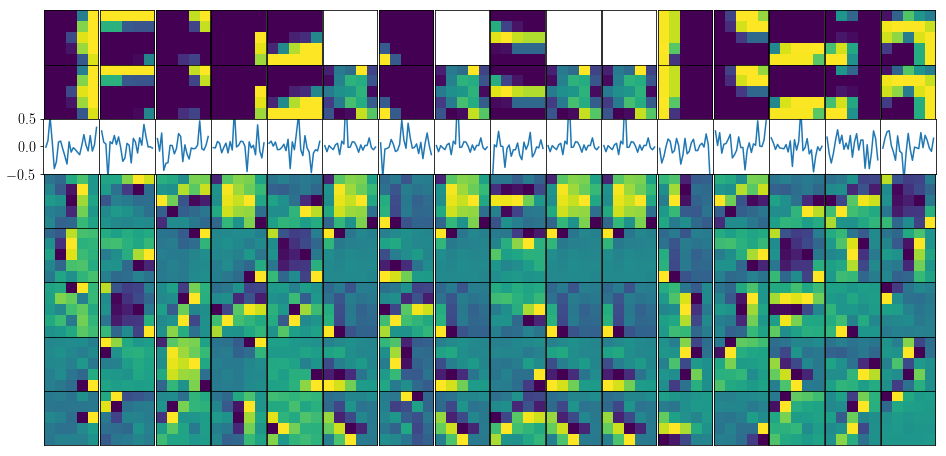

In [43]:
figure(figsize=(16, 8))

ic_ex = 2*arange(5)+1
nrows = 3 + len(ic_ex)
for imx in range(nrecon):
    
    ax = subplot(nrows, nrecon, imx + 1)
    imp = impatchr[:,imx].reshape(patch_size[0], patch_size[1])
    imshow(norm_range(imp))
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = subplot(nrows, nrecon, imx + 1 + nrecon)
    ic_recon = np.dot(ic_code[imx,:], ic_comp)
    ic_reconr = ic_recon.reshape(patch_size[0], patch_size[1])
    imshow(norm_range(ic_reconr))
    ax.set_xticks([])
    ax.set_yticks([])
    
    
    ax = subplot(nrows, nrecon, imx + 1 + 2*nrecon)
    plot(ic_code[imx,:].T/norm(ic_code[imx, :]))
    ax.set_xticks([])
    ax.set_ylim([-0.5, 0.5])
    if imx > 0:
        ax.set_yticks([])

          
    idx_max = np.argsort(abs(ic_code[imx,:]))
  
    for ici,icx in enumerate(ic_ex):
        ax = subplot(nrows, nrecon, imx + 1 + (3+ici)*nrecon)
        ic_compr = ic_comp[idx_max[-icx],:].reshape(patch_size[0], patch_size[1]) 
        ic_compr = ic_compr * ic_code[imx, idx_max[-icx]] # this just flips it if its negative
        imshow(norm_range(ic_compr))
        ax.set_xticks([])
        ax.set_yticks([])
    


In [44]:
def draw_ic_im(ic_coef, ic_comps, nx, ny, patch_size):
    im = np.zeros((int(ny*patch_size[1]), int(nx*patch_size[0])))
    
    cfx = 0
    for ix in range(nx):
        for iy in range(ny):
            ic_recon = np.dot(ic_coef[cfx], ic_comps)
            ic_reconr = ic_recon.reshape(patch_size[0], patch_size[1])
            
            ic_reconr = (ic_reconr + mean01)
            
            ic_reconr[ic_reconr<0] = 0 
            ic_reconr[ic_reconr>1] = 1
            
            
            im[iy*patch_size[1]:(iy+1)*patch_size[1], 
                      ix*patch_size[0]:(ix+1)*patch_size[0], :] = ic_reconr #norm_range(ic_reconr)
            cfx+=1
            
    return im


FHRR images

In [45]:
def fhrr_vec(D, N):
    # pick a random phase
    rphase = 2 * np.pi * np.random.rand(D, N // 2)

    fhrrv = np.zeros((D, 2 * (N//2)))
    fhrrv[:, :(N//2)] = np.cos(rphase)
    fhrrv[:, (N//2):] = np.sin(rphase)
    
    return fhrrv

def fhrr_inv(a):
    a = np.atleast_2d(a)
    
    N2 = a.shape[1] // 2
    b = np.zeros_like(a)
    b[:,:N2] = a[:, :N2]
    b[:,N2:] = -a[:, N2:]
    
    return b

def fhrr_bind(a, b, pa=1, pb=1):
    a = np.atleast_2d(a)
    b = np.atleast_2d(b)    
    
    # we want to do element wise multiply of complex numbers
    N2 = a.shape[1] // 2
    
    
    if not pa==1:
        a = fhrr_pow(a, pa)
        
    if not pb==1:
        b = fhrr_pow(b, pb)
  
    ra = a[:, :N2]
    ia = a[:, N2:]
    rb = b[:, :N2]
    ib = b[:, N2:]
              
    c = np.zeros_like(a)
    
    c[:, :N2] = ra * rb - ia * ib
    c[:, N2:] = ra * ib + rb * ia
    
    return c
 
    
def fhrr_pow(a, pa=1):
    a = np.atleast_2d(a)
    
    N2 = a.shape[1] // 2
    
    ra = a[:, :N2]
    ia = a[:, N2:]
    
    if not pa == 1:
        ma = (ra**2 + ia**2) ** (pa/2) 
        aa = pa * (np.arctan(ia/ra) + (ra < 0) * np.pi)
        ra = ma * np.cos(aa)
        ia = ma * np.sin(aa)
        
    c = np.zeros_like(a)
    c[:, :N2] = ra
    c[:, N2:] = ia
    
    return c
    
def fhrr_roll(a, r=1):
    a = np.atleast_2d(a)
    
    N2 = a.shape[1] // 2
    c = np.zeros_like(a)
    c[:, :N2] = np.roll(a[:, :N2], r, axis=1)
    c[:, N2:] = np.roll(a[:, N2:], r, axis=1)
    
    return c

def fhrr_cc(a, b):
    
    pass

def sparsify(x, tau=1):
    return 0.5*tau*(np.exp(x/tau) - np.exp(-x/tau))

Multiple Unbinding

In [46]:
N = 5000

objD = 120
trfD = 60

obj_vecs = 2 * (np.random.randn(objD, N) < 0) - 1
trf_vecs = 2 * (np.random.randn(trfD, N) < 0) - 1
#obj_vecs = obj_vecs / N**0.5
#trf_vecs = trf_vecs / N**0.5

# This sets the coefficients of the two bound vectors
b_objc = np.zeros(objD)
b_trfc = np.zeros(trfD)

# We'll turn two vectors on by giving them coefficients of 1
b_objc[10] = 1
#b_objc[20] = 0.7

b_trfc[14] = 1
#b_trfc[18] = 1

bound_vec = np.dot(b_objc, obj_vecs) * np.dot(b_trfc, trf_vecs)

# By resonance, I mean positive feedback by having the eigenvectors grow and then be renormalized
# having the eigenvalues as 1 is good enough though (any positive value really e.g. it is 0 vs. 1)
eignorm = 1
obj_resonance = np.dot(np.dot(pinv(obj_vecs), eignorm * np.eye(objD)), obj_vecs)
trf_resonance = np.dot(np.dot(pinv(trf_vecs), eignorm * np.eye(trfD)), trf_vecs)

# So instead of setting the initial vectors to be the sum of all potential,
# we can just set it randomly
obj_state = np.random.randn(N)
trf_state = np.random.randn(N)
#trf_state = trf_vecs.sum(axis=0)
#let_state = let_vecs.sum(axis=0)

obj_state = obj_state / np.linalg.norm(obj_state)
trf_state = trf_state / np.linalg.norm(trf_state)


n_steps = 10

obj_coef_hist = np.zeros((n_steps, objD))
trf_coef_hist = np.zeros((n_steps, trfD))

thal_vec = np.zeros_like(bound_vec)

for i in range(n_steps):
    thal_vec[:] = bound_vec
    
    obj_coef_hist[i,:] = np.dot(obj_vecs, obj_state) / N**0.5
    trf_coef_hist[i,:] = np.dot(trf_vecs, trf_state) / N**0.5
    
    thal_vec -= trf_state * obj_state *N
    
    obj_state = np.dot(obj_resonance, trf_state * thal_vec + obj_state)
    #obj_state = obj_state / np.linalg.norm(obj_state)

    trf_state = np.dot(trf_resonance, obj_state * thal_vec + trf_state) 
    #trf_state = trf_state / np.linalg.norm(trf_state)

    

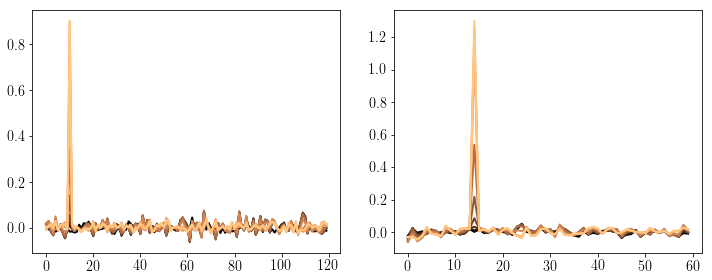

In [47]:
cols = get_cmap('copper', n_steps)

figure(figsize=(10,4))

for i in range(n_steps):
    subplot(121)
    plot(obj_coef_hist[i,:], c=cols(i), lw=2)
    subplot(122)
    plot(trf_coef_hist[i,:], c=cols(i), lw=2)

plt.tight_layout()

HD Map-Seeking Circuit

In [48]:
N=5000
icD = len(which_pcs)
ic_hyperpatch = fhrr_vec(icD, N)

nx_patch = 8
ny_patch = 6

loc_hyperbase = fhrr_vec(2, N) #2*(np.random.randn(2, N) < 0) - 1

locD = nx_patch * ny_patch
loc_vecs = np.zeros((locD, N))
c=0
code_vecs = []

for ix in range(nx_patch):
    for iy in range(ny_patch):
        
        code_v = fhrr_bind(loc_hyperbase[[0],:], loc_hyperbase[[1],:], pa=(ix+1), pb=(iy+1))
        loc_vecs[c, :] = code_v
        c+=1
        
        #code_v = fhrr_bind(fhrr_roll(loc_hyperbase[[0],:], ix+1), 
        #                   fhrr_roll(loc_hyperbase[[1],:], iy+1))
        ic_code = fhrr_bind(np.tile(code_v, (icD, 1)), ic_hyperpatch)
        
        
        code_vecs.append(ic_code)
        

def svd_whiten(X):

    U, s, Vt = np.linalg.svd(X, full_matrices=False)

    # U and Vt are the singular matrices, and s contains the singular values.
    # Since the rows of both U and Vt are orthonormal vectors, then U * Vt
    # will be white
    X_white = np.dot(U, Vt)

    return X_white

In [50]:
#impatch = train_impatches[:,:,0]

from scipy.misc import imresize

digits = [0,1,2,3,4,5,6,7,8,9]

digit_ims = []
dgim_size = (patch_size[0],patch_size[1])

for i in range(X_train.shape[0]):
    
for d in digits:

    imtext = np.array(font.getmask(l))
    imsize = font.getsize(l)

    imtext = np.tile(imtext.reshape((imsize[1], imsize[0], 1)), (1,1,3))
    imtext = imresize(imtext, 1.8)
    #print imtext.shape
    imtext = imtext[:patch_size[0], :patch_size[1], :]
    #print imtext.shape
    
    imsize = imtext.shape
    
    fim = np.zeros(fim_size)
    
    fimr = np.floor((fim_size[0] - imsize[0])/2)
    fimc = np.floor((fim_size[1] - imsize[1])/2)
    
    fim[fimr:(fimr+imsize[0]), fimc:(fimc+imsize[1]), :] = imtext/255
    
    font_ims.append(1-fim)
    
    #imtext = imtext.reshape((imsize[1], imsize[0]))
    #imshow(imtext)
    
imshow(font_ims[0])

In [51]:
np.squeeze(impatch).shape

(5, 5)

In[937]
http://128.32.158.211:8888/notebooks/HDlanguageDetection/resonance_hdmsc-decorr-170131.ipynb

In [ ]:
fontvecs = np.zeros((len(font_ims), N))
ic_code = np.zeros((len(font_ims), icD))
for let in range(len(font_ims)):
    imp = font_ims[let]
    impatchr = imp.reshape((-1, 1)).copy()
    impatchr[impatchr>mean01] = mean01
    impatchr -= mean01

    ic_c = linalg.lstsq(ic_comp.T, impatchr)
    ic_code[let, :] = ic_c[0].T
    fontvecs[let, :] = np.dot(ic_code[let,:], ic_hyperpatch)